# Réduction de dimension par ACP

On souhaite diminuer la dimension des séries temporelles (à 4 bandes) pour qu'elles soient univariées pour chaque pixel.

In [1]:
from selection_pixels_dtw import *
from sklearn.decomposition import PCA
import os
import itertools
from PIL import Image
import rasterio as rio
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
# List of target pixels
pixels_de_interet = pix_danone + pix_agri + pix_ensta + pix_apt + pix_lac + pix_foret
len(pixels_de_interet)

54

In [47]:
# Pour le fil rouge
dir = "../../../images-fil-rouge"
images_list_original = [x for x in os.listdir(dir) if x.endswith(".tif")]
images_list_original.pop(22) # On enlève l'image 22 qui est une image erronée
images_list_original

['crop_SENTINEL2A_20230902-105733-697_L2A_T31UDQ_C_V3-1.tif',
 'crop_SENTINEL2B_20200408-110721-352_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2A_20181018-105349-280_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2A_20230607-110728-178_L2A_T31UDQ_C_V3-1.tif',
 'crop_SENTINEL2A_20161227-105527-361_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2B_20230403-110728-044_L2A_T31UDQ_C_V3-1.tif',
 'crop_SENTINEL2A_20200917-105732-986_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2B_20220617-110728-714_L2A_T31UDQ_C_V3-0.tif',
 'crop_SENTINEL2B_20180804-105022-459_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2B_20180926-110028-459_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2B_20200319-110724-871_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2A_20200602-110730-943_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2A_20210227-110724-513_L2A_T31UDQ_C_V2-2.tif',
 'crop_SENTINEL2B_20220803-105733-039_L2A_T31UDQ_C_V3-0.tif',
 'crop_SENTINEL2B_20210301-105727-281_L2A_T31UDQ_C_V2-2.tif',
 'crop_S

In [49]:
# Getting the pixel values for each image
nband = 4
images_list_beforePCA = np.zeros((len(images_list_original), len(pixels_de_interet), nband))
for image in images_list_original:
    matrice = np.zeros((len(pixels_de_interet),nband))
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)            
        band3 = ds.read(3)
        band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,0] = band1[pixel[0], pixel[1]]
        matrice[j,1] = band2[pixel[0], pixel[1]]
        matrice[j,2] = band3[pixel[0], pixel[1]]
        matrice[j,3] = band4[pixel[0], pixel[1]]
    images_list_beforePCA[images_list_original.index(image)] = matrice

In [50]:
# Reshaping to apply PCA
images_list_beforePCA.reshape((len(images_list_original)*len(pixels_de_interet),nband)).shape

# Applying PCA with 1 component
pca = PCA(n_components=1)
images_list_afterPCA = pca.fit_transform(images_list_beforePCA.reshape((len(images_list_original)*len(pixels_de_interet),nband)))
images_list_afterPCA = images_list_afterPCA.reshape((len(images_list_original), len(pixels_de_interet)))

(7560, 4)

In [52]:
# Reshaping into time series
TS_after_pca = images_list_afterPCA.T

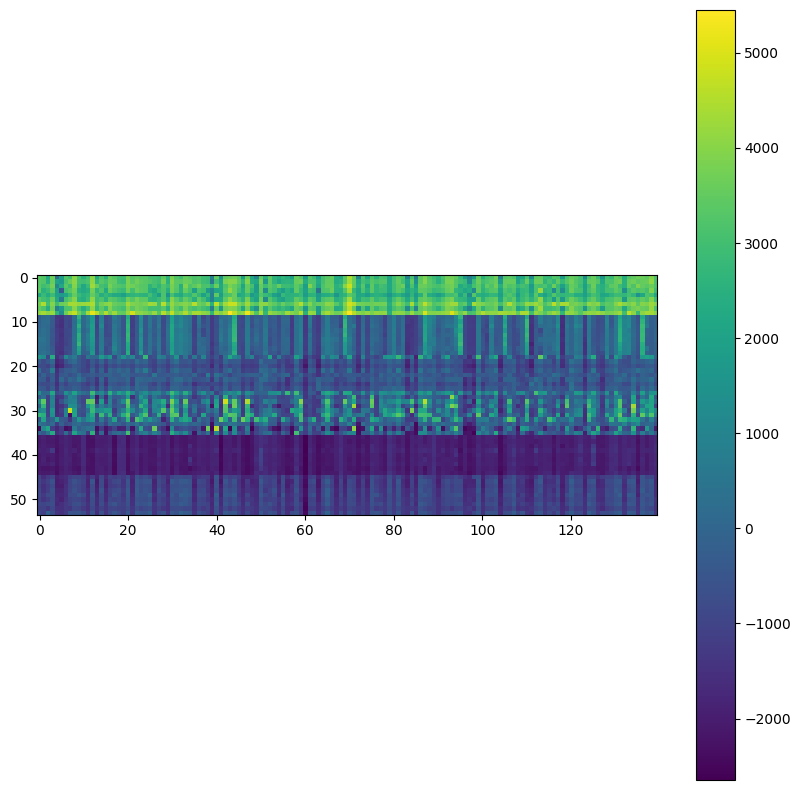

In [53]:
#Looking for a pixels
plt.figure(figsize=(10,10))
plt.imshow(TS_after_pca)
plt.colorbar()
plt.show()

## Clustering

In [56]:
from cookie_clusters import *

yhat = kmeans_dtw(TS_after_pca,6,5000)

In [58]:
import collections

def affichage(yhat,pix_interet):
    name = ''
    dico = collections.Counter(yhat)
    for key in list(dico.keys()):
        dico[key] = [f'number of vectors = {dico[key]}'] 
        for index,pos in zip(yhat,range(len(yhat))):
            if index == key:
                if 0<=pos<=8: name = 'pix_danone'
                elif 9<=pos<=17: name = 'pix_agri'
                elif 18<=pos<=26: name = 'pix_ensta'
                elif 27<=pos<=35: name = 'pix_apt'
                elif 36<=pos<=44: name = 'pix_lac'
                elif 45<=pos<=53: name = 'pix_foret'

                dico[key].append(f'{pix_interet[pos]}:{name}')

    for key in dico:
        print(f'cluster numero {key}:\n-------------------------------')
        for part in dico[key]:
            print(f'{part}')
        print('-------------------------------')

affichage(yhat,pixels_de_interet)

cluster numero 4:
-------------------------------
number of vectors = 9
[383, 497]:pix_danone
[383, 500]:pix_danone
[387, 501]:pix_danone
[383, 504]:pix_danone
[387, 505]:pix_danone
[384, 508]:pix_danone
[388, 509]:pix_danone
[384, 504]:pix_danone
[386, 504]:pix_danone
-------------------------------
cluster numero 5:
-------------------------------
number of vectors = 17
[318, 438]:pix_agri
[322, 435]:pix_agri
[324, 433]:pix_agri
[329, 429]:pix_agri
[333, 426]:pix_agri
[337, 424]:pix_agri
[339, 422]:pix_agri
[344, 418]:pix_agri
[350, 414]:pix_agri
[447, 618]:pix_ensta
[433, 617]:pix_ensta
[408, 444]:pix_apt
[412, 446]:pix_apt
[412, 463]:pix_apt
[407, 465]:pix_apt
[405, 455]:pix_apt
[401, 446]:pix_apt
-------------------------------
cluster numero 1:
-------------------------------
number of vectors = 9
[454, 627]:pix_ensta
[457, 632]:pix_ensta
[459, 625]:pix_ensta
[450, 641]:pix_ensta
[443, 636]:pix_ensta
[439, 629]:pix_ensta
[405, 448]:pix_apt
[414, 440]:pix_apt
[420, 458]:pix_apt
--